## Load Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [2]:
# Load dataset
data = pd.read_csv(r"C:\Users\navya\Downloads\hotel_bookings.csv\hotel_bookings.csv")
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
# Handling missing values
data['country'].fillna(data['country'].mode()[0], inplace=True)
data['agent'].fillna(0, inplace=True)
data['children'].fillna(0, inplace=True)
data.drop('company', axis=1, inplace=True)
print(data.isnull().sum().sum())

0


In [4]:
# Removing the rows where there are no guests.
data = data[~((data['adults'] == 0) & (data['children'] == 0) & (data['babies'] == 0))]
data.shape

(119210, 31)

## Data preprocessing

In [5]:
# Define feature and Target
Features = ['hotel','lead_time','deposit_type','agent','customer_type']
Target = 'is_canceled'

X = data[Features]
y = data[Target]
X.head(3)

,hotel,lead_time,deposit_type,agent,customer_type
0,Resort Hotel,342,No Deposit,0.0,Transient
1,Resort Hotel,737,No Deposit,0.0,Transient
2,Resort Hotel,7,No Deposit,0.0,Transient


In [6]:
# Encode categorical features
X_encode = df_encoded = pd.get_dummies(X, columns=['hotel','deposit_type', 'customer_type'], drop_first=True)

# split data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_encode,y,test_size=0.2,stratify=y,random_state=41)

# Scale numerical features
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

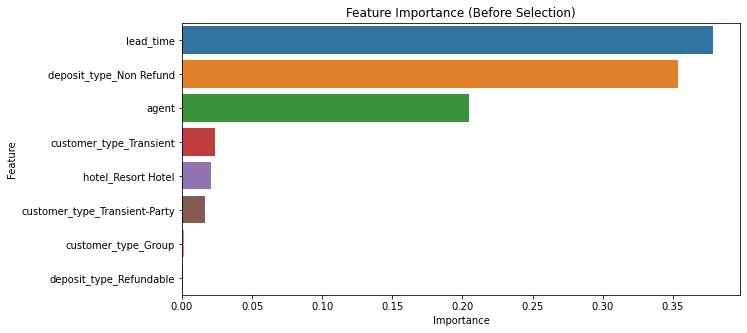

In [9]:
rf = RandomForestClassifier(n_estimators=200, random_state=41)
rf.fit(X_train_sc, y_train)

# Feature Importance Plot (Before Selection)
importances = rf.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (Before Selection)')
plt.show()

In [13]:
# Recursive Feature Elimination (RFE)
rfe_selector = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=5)
rfe_selector.fit(X_train_sc, y_train)

selected_features = X_train.columns[rfe_selector.support_]
# Train Model with Selected Features
X_train_selected = X_train_sc[:, rfe_selector.support_]
X_test_selected = X_test_sc[:, rfe_selector.support_]

## Model Selection and Evaluation

In [14]:
# Function to evaluate models
def evaluate_model(model,X_test,y_test,name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
    
    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC AUC Score: {roc_auc}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


In [15]:
# Train Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_sc, y_train)
evaluate_model(lr, X_test_sc, y_test, "Logistic Regression")


Logistic Regression Performance:
Accuracy: 0.7505
ROC AUC Score: 0.7626630589526222
Confusion Matrix:
[[14691   311]
 [ 5637  3203]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.98      0.83     15002
           1       0.91      0.36      0.52      8840

    accuracy                           0.75     23842
   macro avg       0.82      0.67      0.68     23842
weighted avg       0.79      0.75      0.72     23842



In [16]:
# Train Random Forest
dt = DecisionTreeClassifier(random_state=41)
dt.fit(X_train_sc, y_train)
evaluate_model(dt,X_test_sc,y_test,"Decision Tree")


Decision Tree Performance:
Accuracy: 0.7837
ROC AUC Score: 0.8482319665070298
Confusion Matrix:
[[13358  1644]
 [ 3512  5328]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84     15002
           1       0.76      0.60      0.67      8840

    accuracy                           0.78     23842
   macro avg       0.78      0.75      0.76     23842
weighted avg       0.78      0.78      0.78     23842



In [17]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=41)
rf.fit(X_train_sc, y_train)
evaluate_model(rf, X_test_sc, y_test, "Random Forest")


Random Forest Performance:
Accuracy: 0.7841
ROC AUC Score: 0.8560600328704288
Confusion Matrix:
[[13316  1686]
 [ 3462  5378]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84     15002
           1       0.76      0.61      0.68      8840

    accuracy                           0.78     23842
   macro avg       0.78      0.75      0.76     23842
weighted avg       0.78      0.78      0.78     23842



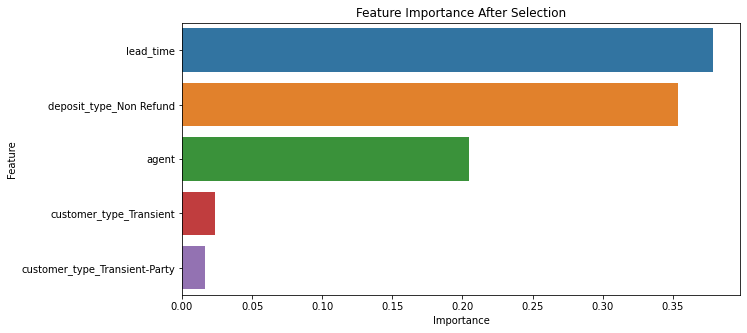

In [18]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df[importance_df['Feature'].isin(selected_features)])
plt.title('Feature Importance After Selection')
plt.show()

## Improve Model Performance

In [22]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid for Random Forest
rf_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10,15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_tuner = RandomizedSearchCV(RandomForestClassifier(random_state=41), rf_params, n_iter=10, cv=5, n_jobs=-1, random_state=41)
rf_tuner.fit(X_train_sc, y_train)

# Best Random Forest model
rf_best = rf_tuner.best_estimator_
print(rf_tuner.best_estimator_)
# Evaluate again
evaluate_model(rf_best, X_test_sc, y_test,"Tuned Random Forest")

RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=5,
                       random_state=41)

Tuned Random Forest Performance:
Accuracy: 0.7847
ROC AUC Score: 0.8609352237197936
Confusion Matrix:
[[13971  1031]
 [ 4102  4738]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84     15002
           1       0.82      0.54      0.65      8840

    accuracy                           0.78     23842
   macro avg       0.80      0.73      0.75     23842
weighted avg       0.79      0.78      0.77     23842



## **Final Insights**  



✅ **Tuned Random Forest is the Best-Performing Model**  
   - Achieved **78.47% accuracy** and an **ROC AUC score of 0.86**, indicating a well-balanced model.  

✅ **Stratified Sampling Enhanced Consistency**  
   - Ensured better class representation, improving model robustness.  

✅ **Feature Selection Considerations**  
   - Removing low-importance features **lowered accuracy and ROC AUC score**, proving their subtle contribution.  
   - The best-performing model was **Random Forest with max_depth=15, min_samples_split=5, and min_samples_leaf=2**.  
